1. Setup — imports & constants

In [ ]:
# Step 1: imports and constants
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# File path (change if needed)
DATA_PATH = ("/content/manufacturing_dataset_1000_samples.xlsx.csv")
RANDOM_STATE = 42

2. Load the data and inspect

In [ ]:
# Step 2: load and inspect
df = pd.read_csv("/content/manufacturing_dataset_1000_samples.xlsx.csv")
print("Rows, Columns:", df.shape)
df.head(5)

Rows, Columns: (1000, 19)


,Timestamp,Injection_Temperature,Injection_Pressure,Cycle_Time,Cooling_Time,Material_Viscosity,Ambient_Temperature,Machine_Age,Operator_Experience,Maintenance_Hours,Shift,Machine_Type,Material_Grade,Day_of_Week,Temperature_Pressure_Ratio,Total_Cycle_Time,Efficiency_Score,Machine_Utilization,Parts_Per_Hour
0,2023-01-01 00:00:00,221.0,136.0,28.7,13.6,375.5,28.0,3.8,11.2,64,Evening,Type_B,Economy,Thursday,1.625,42.3,0.063,0.510,36.5
1,2023-01-01 01:00:00,213.3,128.9,34.5,14.0,215.8,22.6,6.8,6.3,58,Night,Type_A,Standard,Wednesday,1.655,48.5,0.037,0.389,29.9
2,2023-01-01 02:00:00,222.8,115.9,19.9,9.5,307.0,25.3,4.2,9.6,47,Day,Type_A,Standard,Monday,1.922,29.4,0.061,0.551,56.9
3,2023-01-01 03:00:00,233.3,105.3,39.2,13.1,137.8,26.0,9.2,8.6,49,Evening,Type_A,Premium,Saturday,2.215,52.3,0.054,0.293,31.0
4,2023-01-01 04:00:00,212.2,125.5,45.0,9.9,298.2,23.6,6.2,23.0,49,Night,Type_B,Premium,Monday,1.691,54.9,0.145,0.443,15.0


3. Check for missing values and column names

In [ ]:
# Step 3: missing values and columns
print("Columns:", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())

Columns: ['Timestamp', 'Injection_Temperature', 'Injection_Pressure', 'Cycle_Time', 'Cooling_Time', 'Material_Viscosity', 'Ambient_Temperature', 'Machine_Age', 'Operator_Experience', 'Maintenance_Hours', 'Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week', 'Temperature_Pressure_Ratio', 'Total_Cycle_Time', 'Efficiency_Score', 'Machine_Utilization', 'Parts_Per_Hour']

Missing values:
 Timestamp                      0
Injection_Temperature          0
Injection_Pressure             0
Cycle_Time                     0
Cooling_Time                   0
Material_Viscosity            20
Ambient_Temperature           20
Machine_Age                    0
Operator_Experience           20
Maintenance_Hours              0
Shift                          0
Machine_Type                   0
Material_Grade                 0
Day_of_Week                    0
Temperature_Pressure_Ratio     0
Total_Cycle_Time               0
Efficiency_Score               0
Machine_Utilization            0
Parts_Per_Hour 

4. Simple EDA: distribution of target and a pairwise view

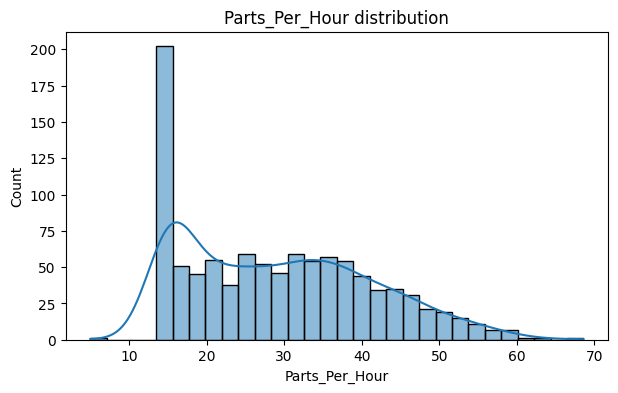

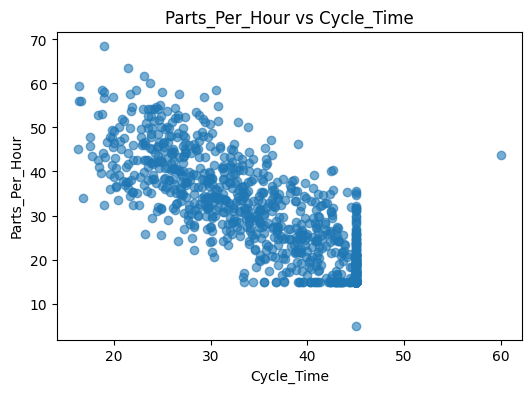

In [ ]:
# Step 4: simple exploratory plots
plt.figure(figsize=(7,4))
sns.histplot(df['Parts_Per_Hour'], bins=30, kde=True)
plt.title('Parts_Per_Hour distribution')
plt.show()

# Quick scatter: Parts_Per_Hour vs Cycle_Time (example)
plt.figure(figsize=(6,4))
plt.scatter(df['Cycle_Time'], df['Parts_Per_Hour'], alpha=0.6)
plt.xlabel('Cycle_Time')
plt.ylabel('Parts_Per_Hour')
plt.title('Parts_Per_Hour vs Cycle_Time')
plt.show()

5. Handle missing values (simple and transparent)

In [ ]:
# Step 5: handle missing values in an explicit, simple way

# columns mentioned earlier as having missing values
# we'll fill numeric columns with median (robust) and categorical with mode

numeric_fill_cols = ['Material_Viscosity', 'Ambient_Temperature', 'Operator_Experience']
for c in numeric_fill_cols:
    if c in df.columns:
        median_val = df[c].median()
        df[c] = df[c].fillna(median_val)
        print(f"Filled {c} missing with median: {median_val}")

# If any categorical had missing, fill with most frequent value (example)
cat_cols = ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
for c in cat_cols:
    if c in df.columns:
        mode_val = df[c].mode()[0]
        df[c] = df[c].fillna(mode_val)
        print(f"Filled {c} missing with mode: {mode_val}")

Filled Material_Viscosity missing with median: 242.7
Filled Ambient_Temperature missing with median: 22.9
Filled Operator_Experience missing with median: 22.1
Filled Shift missing with mode: Day
Filled Machine_Type missing with mode: Type_A
Filled Material_Grade missing with mode: Standard
Filled Day_of_Week missing with mode: Friday


6. Prepare features and target


In [ ]:
# Step 6: features and target
target = 'Parts_Per_Hour'

# define categorical and numeric feature lists (explicit so teacher can see)
categorical_features = ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
# numeric: take all numeric columns except the target
numeric_features = [c for c in df.select_dtypes(include=np.number).columns.tolist() if c != target]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# X and y
X = df[numeric_features + [c for c in categorical_features if c in df.columns]]
y = df[target]

Numeric features: ['Injection_Temperature', 'Injection_Pressure', 'Cycle_Time', 'Cooling_Time', 'Material_Viscosity', 'Ambient_Temperature', 'Machine_Age', 'Operator_Experience', 'Maintenance_Hours', 'Temperature_Pressure_Ratio', 'Total_Cycle_Time', 'Efficiency_Score', 'Machine_Utilization']
Categorical features: ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']


7. Split into train and test

In [ ]:
# Step 7: train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (800, 17) Test size: (200, 17)


8. Preprocessing pipelines (impute again + scale + encode)

In [ ]:
# Step 8: preprocessor: simple and clear

# numeric transformer: impute (median) then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical transformer: impute (most frequent) then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, [c for c in categorical_features if c in X.columns])
])

9. Train a simple Linear Regression model (baseline)

In [ ]:
# Step 9: pipeline with linear regression
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# train
model_pipeline.fit(X_train, y_train)
print("Model trained (Linear Regression).")

Model trained (Linear Regression).


10. Evaluate the model (RMSE, MAE, R2)

Test MSE: 12.308
Test RMSE: 3.508
Test MAE: 2.718
Test R2: 0.906


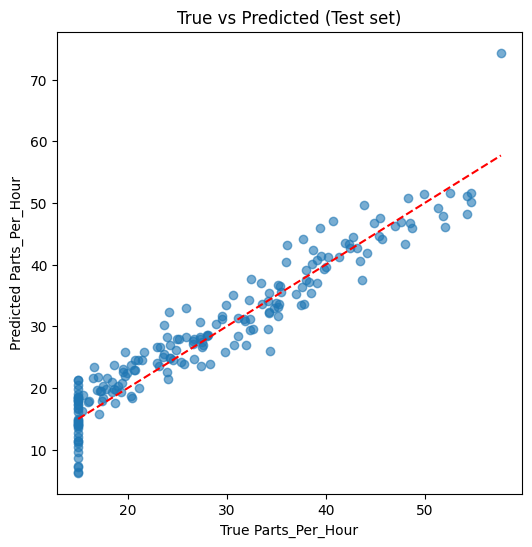

In [ ]:
# Step 10: evaluate on test set
y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test R2: {r2:.3f}")

# simple plot: true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Parts_Per_Hour')
plt.ylabel('Predicted Parts_Per_Hour')
plt.title('True vs Predicted (Test set)')
plt.show()

11. (Optional) Try a slightly better regularized model (Ridge)

In [ ]:
# Step 11: try Ridge regression for small improvement
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"Ridge RMSE on test: {rmse_ridge:.3f}")

# Choose better of the two
if rmse_ridge < rmse:
    final_model = ridge_pipeline
    print("Ridge selected as final model.")
else:
    final_model = model_pipeline
    print("Linear Regression kept as final model.")

Ridge RMSE on test: 3.508
Linear Regression kept as final model.


12. Save the final model to disk

In [ ]:
# Step 12: save model to model/model.joblib
os.makedirs("model", exist_ok=True)
joblib.dump(final_model, "model/model.joblib")
print("Saved final model to model/model.joblib")

Saved final model to model/model.joblib


In [ ]:
# Step 14: map coefficients to feature names (only for linear models)
# this works if linear or ridge is used; get preprocessor and regressor
pre = final_model.named_steps['preprocessor']
reg = final_model.named_steps['regressor']

# numeric feature names
num_names = numeric_features

# categorical feature names after one-hot
ohe = pre.named_transformers_['cat'].named_steps['onehot']
cat_names = list(ohe.get_feature_names_out([c for c in categorical_features if c in X.columns]))

feature_names = num_names + cat_names
coefficients = reg.coef_

coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df = coef_df.reindex(coef_df.coefficient.abs().sort_values(ascending=False).index)
coef_df.head(10)

,feature,coefficient
22,Day_of_Week_Friday,-4.114573e+12
25,Day_of_Week_Sunday,-4.114573e+12
24,Day_of_Week_Saturday,-4.114573e+12
23,Day_of_Week_Monday,-4.114573e+12
27,Day_of_Week_Tuesday,-4.114573e+12
26,Day_of_Week_Thursday,-4.114573e+12
28,Day_of_Week_Wednesday,-4.114573e+12
18,Machine_Type_Type_C,-1.444896e+12
17,Machine_Type_Type_B,-1.444896e+12
16,Machine_Type_Type_A,-1.444896e+12


In [ ]:
import pickle
import json
import joblib

# model saving
with open('linear_regression_model.pkl','wb') as f:
  pickle.dump(final_model, f)
feature_columns = X.columns.tolist()
with open("feature_columns.json", "w") as f:
  json.dump(feature_columns, f)


print("model, scaler (if part of pipeline), and feature columns saved.")

model, scaler (if part of pipeline), and feature columns saved.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop(columns=['Parts_Per_Hour'])
y = df['Parts_Per_Hour']

# 1️⃣ One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# 2️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3️⃣ Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4️⃣ Train your model
from sklearn.linear_model import LinearRegression
final_model = LinearRegression()
final_model.fit(X_train_scaled, y_train)

# 5️⃣ Save both model and scaler
import joblib
joblib.dump(final_model, 'linear_regression_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("✅ Model and scaler have been saved successfully!")

✅ Model and scaler have been saved successfully!


In [ ]:
!ls

feature_columns.json			     model	  scaler.pkl
linear_regression_model.pkl		     model.pkl
manufacturing_dataset_1000_samples.xlsx.csv  sample_data


In [ ]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Assuming 'df' is already loaded from a previous cell
# Step 2: load and inspect
DATA_PATH = ("/content/manufacturing_dataset_1000_samples.xlsx.csv")
df = pd.read_csv(DATA_PATH)

# Step 5: handle missing values
numeric_fill_cols = ['Material_Viscosity', 'Ambient_Temperature', 'Operator_Experience']
for c in numeric_fill_cols:
    if c in df.columns:
        median_val = df[c].median()
        df[c] = df[c].fillna(median_val)

# Separate features and target
X = df.drop(columns=['Parts_Per_Hour'])
y = df['Parts_Per_Hour']

# Define numeric and categorical features
numeric_features = [c for c in X.select_dtypes(include=np.number).columns.tolist()]
categorical_features = [c for c in X.select_dtypes(include='object').columns.tolist()]

# Create preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train your model
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

final_model.fit(X_train, y_train)

# Save the trained model and scaler
joblib.dump(final_model, 'linear_regression_model.pkl')
# The scaler is now part of the pipeline, so we don't need to save it separately.
# joblib.dump(scaler, 'scaler.pkl')


print("✅ Model and scaler saved successfully!")

✅ Model and scaler saved successfully!


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer # Import SimpleImputer
import joblib

# Load dataset
data = pd.read_csv("/content/manufacturing_dataset_1000_samples.xlsx.csv")

# Split features and target
X = data.drop("Parts_Per_Hour", axis=1)
y = data["Parts_Per_Hour"]

# Separate categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(exclude=['object']).columns

# Preprocessing pipeline with imputation
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', 'passthrough')]), numerical_cols) # Added imputation and scaling for numeric features
])

# Full pipeline with model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train
model.fit(X, y)

# ✅ Save model with same scikit-learn version (1.3.2)
joblib.dump(model, "model.pkl")

print("Model retrained and saved successfully!")

Model retrained and saved successfully!


In [ ]:
!pip install -U scikit-learn==1.4.2 joblib==1.3.2

  Using cached scikit_learn-1.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.6.0 requires scikit-learn>=1.5, but you have scikit-learn 1.4.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
